(3158, 16) (3158, 9)


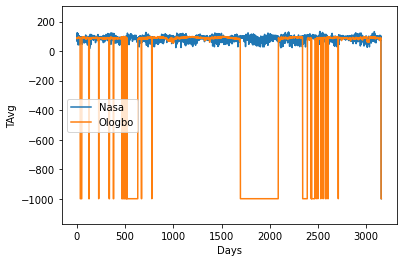

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


##################### LOAD DATA  ###################

# pd_nasa = pd.read_csv("Restricted_NASA_OLOGBO_Date_999.csv", sep=";", header=0)
pd_nasa = pd.read_csv("OLOGBO_AllNASA_999.csv", sep=";", header=0)
pd_nasa = pd_nasa.drop(pd_nasa.columns[[0, 1, 2]],axis = 1)
# pd_ologbo = pd.read_csv("RestrictedDataOlogbo999.csv", sep=";", header=0)
pd_ologbo = pd.read_csv("OLOGBO__999.csv", sep=";", header=0)
pd_ologbo = pd_ologbo.drop(pd_ologbo.columns[[0, 1, 2]],axis = 1)

nasa_data = pd_nasa.astype(np.float32).values
# nasa_data[:, [1, 0]] = nasa_data[:, [0, 1]]
ologbo_data = pd_ologbo.astype(np.float32).values

print(nasa_data.shape, ologbo_data.shape)


plt.plot(nasa_data[:,5])
plt.plot(ologbo_data[:,5])
plt.margins(0.05,0.15)
# plt.ylim([-4,4])
plt.rcParams["figure.figsize"] = (20,6)
plt.xlabel("Days")
plt.ylabel("TAvg")
plt.legend(['Nasa', 'Ologbo'])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, SpatialDropout1D,BatchNormalization,Flatten, Dropout, Input, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import json


def get_samples(col_to_predict, split_proportion=0.7, sample_size=6, pos="mid"):

    missing_rows = np.argwhere(ologbo_data[:,col_to_predict] == -999).flatten()
    sample_array = np.arange(sample_size)

    x = []
    y = []

    for i in range(len(nasa_data) - sample_size):
        local_samples = sample_array + i
        if True not in np.isin(missing_rows, local_samples):
            x.append(nasa_data[local_samples])
            if pos == "mid":
                y.append(ologbo_data[i+int(sample_size/2), col_to_predict]) ## mid value
            else:
                y.append(ologbo_data[i+sample_size-1, col_to_predict]) ## last value

    x = np.array(x)
    y = np.array(y).reshape(-1,1)

    split_index = int(len(y) * split_proportion)

    x_train, x_test = x[0:split_index], x[split_index+1:]
    y_train, y_test = y[0:split_index], y[split_index+1:]

    x_scaler = MinMaxScaler()
    x_train_s = x_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test_s = x_scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    y_scaler = MinMaxScaler()
    y_train_s = y_scaler.fit_transform(y_train)
    y_test_s = y_scaler.transform(y_test)

    return x_train, x_test, y_train, y_test, x_train_s, x_test_s, y_train_s, y_test_s, x_scaler, y_scaler



def train_model(model, x_train_s, x_test_s, y_train_s, y_test_s, model_name):
    model_file = "results/" + model_name + ".hdf5"
    mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', mode='min') 
    earlyStopping = EarlyStopping(monitor='val_loss', patience=220, verbose=0, mode='min') 
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=120, verbose=0, min_delta=1e-6, mode='min')

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    model.fit(  x_train_s, y_train_s, 
                epochs=15000, 
                batch_size=3000, 
                shuffle=True, 
                verbose=0,
                callbacks=[reduce_lr_loss, earlyStopping, mcp_save],
                validation_data = (x_test_s, y_test_s))

    return model_file, model

def validate_prediction(model_file, model_name, col_name, model, x_test_s, y_test, y_scaler, show=True):
    model.load_weights(model_file)
    y_predict = model.predict(x_test_s)
    y_predict = y_scaler.inverse_transform(y_predict)
    RMSE = np.sqrt(np.mean((y_test-y_predict)**2))
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    MAPE = mean_absolute_percentage_error(y_test, y_predict)
    R2 = r2_score(y_test, y_predict)

    result_file = open("NASA_benchmark_global.txt", "a")
    result_file.write("-" * 30)
    result_file.write(model_name)
    result_file.write("Model for column " + col_name + " with serie of size " + str(x_test_s.shape[1]) + "\n")
    result_file.write("RMSE: " + str(RMSE) + "\n")
    result_file.write("MAE: " + str(MAE) + "\n")
    result_file.write("MSE: " + str(MSE) + "\n")
    result_file.write("MAPE: " + str(MAPE) + "\n")
    result_file.write("R²: " + str(R2) + "\n")
    result_file.close()

    plt.plot(y_test)
    plt.plot(y_predict)
    # plt.ylim([15, 35])
    plt.rcParams["figure.figsize"] = (20,6)
    plt.xlabel("Days")
    plt.ylabel(col_name)
    plt.legend(["Ologbo", "Predicted"])
    plt.title(model_file)
    plt.savefig('results/'+ model_name +'.png')
    plt.margins(0.05, 0.15)
    if show is True:
        plt.show()
    else:
        plt.close()

    return RMSE, MAE, MSE, MAPE, R2

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalAveragePooling1D, SpatialDropout1D,BatchNormalization,Flatten, \
    Dropout, Input, Bidirectional, LSTM, GRU, DepthwiseConv1D, AveragePooling1D, MaxPooling1D, SeparableConv1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras import Model
import tensorflow_addons as tfa
# from tensorflow_addons.layers import MultiHeadAttention

def dense_model(x_train):##4
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    # model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # model.summary()
    return model

def LSTM_model(x_train): ##4
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Bidirectional(LSTM(16, activation='relu')))
    # model.add(Bidirectional(LSTM(16))) ## CUDNN
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def GRU_model(x_train): ##4
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Bidirectional(GRU(16)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def Conv_model(x_train): ##12
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Conv1D(filters=8, kernel_size=3, padding="same"))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(Conv1D(filters=16, kernel_size=3))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def SepConv_model(x_train):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(SeparableConv1D(32, kernel_size=3, depth_multiplier=2, padding="same", activation='relu'))
    model.add(Conv1D(filters=16, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def DepthConv_model(x_train):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(DepthwiseConv1D(kernel_size=3, padding="same",depth_multiplier=2, activation='relu'))
    model.add(DepthwiseConv1D(kernel_size=3, padding="same",depth_multiplier=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

def transformer(
    x_train,
    head_size=32,
    num_heads=2,
    ff_dim=8,
    num_transformer_blocks=2,
    mlp_units=[32],
    dropout=0.05,
    mlp_dropout=0.1,
):
    inputs = Input(shape=x_train.shape[1:])
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)


split_proportion = 0.7
col_names = ["TMin","TMax","TAverage","HRMin","HRMax","HRAverage","WindSpeed","Rainfall","Rg"]
ranges = [3,4,5,9,16]
positions = ["mid"]
functions = [dense_model, LSTM_model, GRU_model, Conv_model, SepConv_model, DepthConv_model, transformer]

cols_to_predict = [8]

# for col_to_predict in cols_to_predict:
for col_to_predict in range(len(col_names)):
    results = {}
    col_name = col_names[col_to_predict]
    for sample_size in ranges:
        for pos in positions:
            for model_func in functions:
                model_name = "nasa_pred_model_col-" + col_name + "_seriesize-" + str(sample_size) + "_model-" + model_func.__name__ + "_" + pos
                x_train, x_test, y_train, y_test, x_train_s, x_test_s, y_train_s, y_test_s, x_scaler, y_scaler = get_samples(col_to_predict, split_proportion, sample_size, pos=pos)
                model = model_func(x_train)
                model_file, model = train_model(model, x_train_s, x_test_s, y_train_s, y_test_s, model_name)
                RMSE, MAE, MSE, MAPE, R2 = validate_prediction(model_file, model_name, col_name, model, x_test_s, y_test, y_scaler, show=False)
                results[model_name] = {"model":model_func.__name__, "column":col_name, "size":str(sample_size),"RMSE":str(RMSE), "R²":str(R2), "MAE":str(MAE), "MSE":str(MSE), "MAPE":str(MAPE)}
                print("*"*5, model_name, len(x_train), RMSE, "*"*5)
    
    results = sorted(results.items(), key=lambda k_v: k_v[1]['RMSE'])
    with open('results_' + col_name + '.json', 'w') as fp:
        json.dump(results, fp, indent=4)

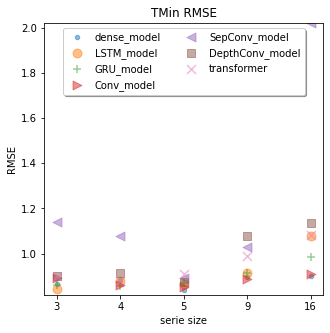

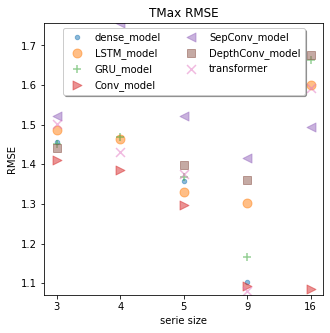

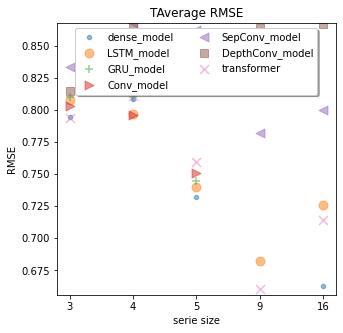

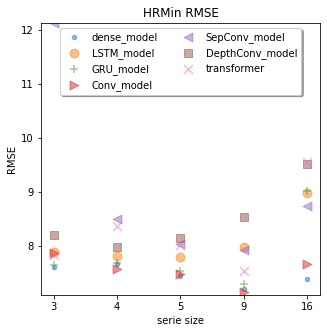

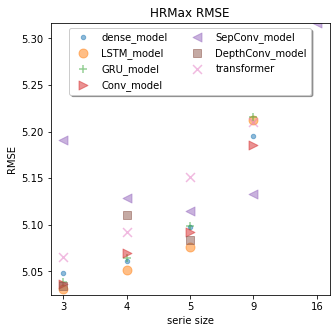

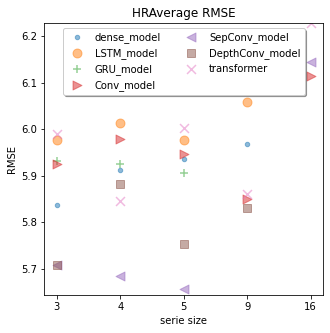

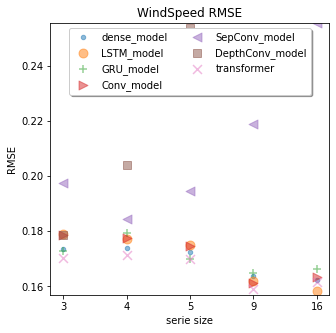

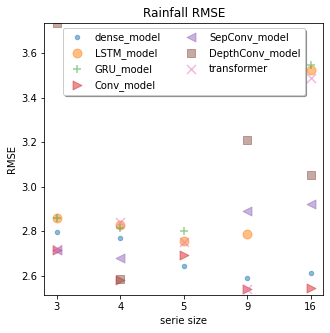

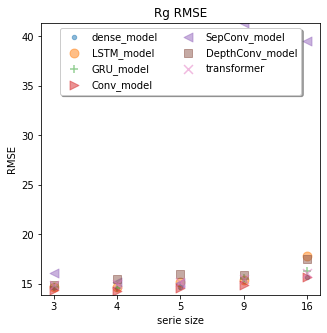

In [17]:
import json

col_names = ["TMin","TMax","TAverage","HRMin","HRMax","HRAverage","WindSpeed","Rainfall","Rg"]
ranges = [3,4,5,9,16]
functions = ["dense_model", "LSTM_model", "GRU_model", "Conv_model", "SepConv_model", "DepthConv_model", "transformer"]
markers = {"dense_model":".", "LSTM_model":"o", "GRU_model":"+", "Conv_model":">", "SepConv_model":"<", "DepthConv_model":"s", "transformer":"x"}
x_axis = np.arange(len(ranges))

for col_name in col_names:
    json_file = open('results_' + col_name + '.json')
    data = json.load(json_file)
    
    series = {}
    for model_func in functions:
        series[model_func] = [0 for x in ranges]
    for d in data:
        d = d[1]
        # print(d["model"], d["size"], d["RMSE"])
        series[d["model"]][ranges.index(int(d["size"]))] = float(d["RMSE"])

    max_ = max(max(series.values()))
    min_ = min(min(series.values()))

    plt.rcParams["figure.figsize"] = (5,5)
    for k,v in series.items():
        plt.scatter(x_axis, v, 80, alpha=0.5, marker=markers[k])  

    plt.xlabel("serie size")
    plt.ylabel("RMSE")
    plt.xticks(x_axis, ranges)
    plt.legend(list(markers.keys()), loc='upper center', ncol=2, fancybox=True, shadow=True)
    
    plt.title(col_name + " RMSE")
    plt.savefig('predictions_'+ col_name + '.png')
    yr = max_ - min_
    min_ = min_ - min(min_r*0.02, yr*0.02)
    # max_r = min_r = yr*0.8
    plt.ylim([min_,max_])
    plt.show()